## Importing Necessary Modules

In [4]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
import torch
from torch import nn
import string
import nltk
from collections import Counter
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from tqdm import tqdm
import ast
import matplotlib.pyplot as plt


## About Data

Data Source: https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

Data contains about 72,000 articles with around 35,000 real news and around 37,000 fake news.



## Load DataSet

In [5]:
data = pd.read_csv("WELFake_Dataset.csv", low_memory=False).drop("Unnamed: 0", axis=1)
print(f"Loaded {data.shape[0]} rows")

Loaded 72134 rows


In [6]:
data.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


## NaN Values

In [7]:
data.isna().sum()

title    558
text      39
label      0
dtype: int64

There is very few rows containing NaN values, so dropping all of them.

In [8]:
print(f"Samples before removing NaNs: {data.shape[0]}")
data.dropna(inplace=True)
print(f"Samples after removing NaNs: {data.shape[0]}")

Samples before removing NaNs: 72134
Samples after removing NaNs: 71537


## Data Preprocessing

### Creating a new columns named feature, concatenating title and text

In [9]:
data['feature'] = data['title'] + " " + data['text']
data.drop(['title', 'text'], axis=1, inplace=True)
data.head()

,label,feature
0,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
2,1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,1,SATAN 2: Russia unvelis an image of its terrif...
5,1,About Time! Christian Group Sues Amazon and SP...


In [10]:
def remove_puncts_and_censored_words(text: str) -> str:
    """Removes censored words and punctuations from the text

    Args:
        text (str): news feature columm

    Returns:
        str: preprocessed text
    """
    # Remove censored words
    censor_removed = " ".join([word for word in text.split(" ") if '*' not in word])
    # Remove punctuations
    punct_free = "".join([letter for letter in censor_removed if letter not in string.punctuation])

    # Replace multiple spaces with one space and lower them
    single_spaced = " ".join(filter(bool, punct_free.split(" "))).lower()
    return single_spaced

def word_tokenize(text: str) -> list[str]:
    """Splits text into words

    Args:
        text (str): preprocessed text

    Returns:
        list(str): word tokens
    """
    return text.split(" ")

def remove_stopwords(tokens: list[str]) -> list[str]:
    """Removes stopwords from the tokens

    Args:
        tokens (list[str]): word tokens

    Returns:
        list[str]: word tokens with stop words removed
    """
    stopwords = nltk.corpus.stopwords.words('english')
    return [t for t in tokens if t not in stopwords]

def preprocess(text: str) ->list[str]:
    """Preprocesses the text

    Args:
        text (str): news feature column

    Returns:
        list[str]: preprocessed tokens
    """
    preprocessed = remove_puncts_and_censored_words(text)
    preprocessed = word_tokenize(preprocessed)
    preprocessed = remove_stopwords(preprocessed)

    return preprocessed

def pad(text: list[int], pad_length: int) -> list[int]:
    """If the text is less than pad_length, pads the text with 0s at the beginning.
    If the text is greater than pad_length, truncates the text to pad_length.
    If the text is equal to pad_length, returns the text as it is.

    Args:
        text (list[int]): preprocessed tokens
        pad_length (int): length to pad the text to

    Returns:
        list[int]: padded text
    """
    if len(text) < pad_length:
        pad_arr = [0] * (pad_length - len(text))
        return pad_arr + text
    elif len(text) > pad_length:
        return text[:pad_length]
    else:
        return text

### Apply Preprocessing

1. Removing censored words and punctuations
2. Word Tokenizing
3. Removing Stopwords

In [11]:
data['preprocessed'] = data['feature'].apply(lambda x: preprocess(x))
data.drop('feature', axis=1,inplace=True)
data.head()

,label,preprocessed
0,1,"[law, enforcement, high, alert, following, thr..."
2,1,"[unbelievable, obama’s, attorney, general, say..."
3,0,"[bobby, jindal, raised, hindu, uses, story, ch..."
4,1,"[satan, 2, russia, unvelis, image, terrifying,..."
5,1,"[time, christian, group, sues, amazon, splc, d..."


## Converting word string tokens into integers

1. Create a dictionary of all words in data with its count
2. Filter out words with only 1 occurence
3. Create a vocabulary of only unique words
4. Convert word tokens into integer using index of word in vocabulary
5. Pad work tokens into length of 300

In [12]:
# List of all words in feature preprocessed column
words = [word for row in data['preprocessed'] for word in row]

# Create a dictionary of words and their counts
word_counts = Counter(words)

# Creating a vocabulary dictionary of words which occur more than once
vocabulary = {word: index + 1 for index, (word, count) in enumerate(word_counts.most_common()) if count > 1} 

words = sorted(vocabulary, key=vocabulary.get, reverse=True)
# Adding _UNK token to the vocabulary
words = ['_UNK'] + words

# Creating a dictionary of words and their indices
w2idx = {word:i for i, word in enumerate(words)}
idx2w = {i:word for i, word in enumerate(words)}

# Encoding the preprocessed feature column
data['encoded'] = data['preprocessed'].apply(lambda x : [w2idx[w] if w in w2idx.keys() else 0 for w in x])

# Padding the encoded feature column to 300
pad_to = 300
data['encoded'] = data['encoded'].apply(lambda x: pad(x, pad_to))

# Save preprocessed data
data.to_csv('preprocessed.csv', index=False)

In [13]:
# Load Preprocessed Data
data = pd.read_csv('preprocessed.csv', low_memory=False)

# Convert encoded column to list
data['encoded'] = data['encoded'].apply(lambda x : ast.literal_eval(x))
data.head()

,label,preprocessed,encoded
0,1,"['law', 'enforcement', 'high', 'alert', 'follo...","[254514, 253979, 254285, 250522, 254185, 25337..."
1,1,"['unbelievable', 'obama’s', 'attorney', 'gener...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,0,"['bobby', 'jindal', 'raised', 'hindu', 'uses',...","[245310, 242683, 253712, 246833, 252352, 25434..."
3,1,"['satan', '2', 'russia', 'unvelis', 'image', '...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,"['time', 'christian', 'group', 'sues', 'amazon...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
# Get data as numpy array
data_np = data[['encoded', 'label']].to_numpy()

# Delete data to free up memory
del(data)

In [15]:
# Create a list of features and labels
X = []
y = []
for idx, (feat, label) in enumerate(data_np):
    X.append(feat)
    y.append(label)
    

## Train, Validation, Test Split

In [16]:

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, random_state=0, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, stratify=y_train_val, random_state=0,test_size=0.2)


## DataLoader

In [17]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = torch.tensor(sample, dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        return sample, label
    
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
test_dataset = MyDataset(X_test, y_test)


In [18]:
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Model Building

In [10]:
class NewsClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, n_classes, drop_prob=0.5):

        super(NewsClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers =n_layers)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_dim, n_classes)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        batch_size = x.size(0)
        h_0 = Variable(torch.zeros(1*self.n_layers, batch_size, self.hidden_dim)).to(device)
        c_0 = Variable(torch.zeros(1*self.n_layers, batch_size, self.hidden_dim)).to(device)


        x = x.long()
        embeds = self.embedding(x)

        lstm_out, (h, _) = self.lstm(embeds, (h_0, c_0))

        final_hidden_state = h[-1]

        out = self.dropout(final_hidden_state)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out[:,-1]

        



## Configurations

In [11]:
vocab_size = 254575
embedding_dim = 512
hidden_dim = 400
n_layers = 2
n_classes = 2
model = NewsClassifier(vocab_size=vocab_size, embedding_dim=embedding_dim, hidden_dim=hidden_dim
                       , n_layers=n_layers, n_classes=n_classes).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training

In [12]:
def train(model, trainloader, optimizer, criterion):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels.float())
        train_running_loss += loss.item()
        # calculate the accuracy
        preds = torch.round(outputs)
        # _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))

    return epoch_loss, epoch_acc
# validation

def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels.float())
            valid_running_loss += loss.item()
            # calculate the accuracy
            preds = torch.round(outputs)

            # _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [13]:
start_epoch = 0
epochs = 10
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(start_epoch, start_epoch+ epochs):
    print(f"[INFO]: Epoch {epoch+1} of {start_epoch + epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, 
                                              optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_dataloader,  
                                                 criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)


    print(f"Training: Loss {train_epoch_loss:.3f}, Acc {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

    


print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 10
Training


100%|██████████| 179/179 [00:49<00:00,  3.64it/s]


Validation


100%|██████████| 45/45 [00:03<00:00, 14.25it/s]


Training: Loss 0.367, Acc 83.813
Validation loss: 0.269, validation acc: 88.878
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


100%|██████████| 179/179 [00:46<00:00,  3.89it/s]


Validation


100%|██████████| 45/45 [00:04<00:00,  9.61it/s]


Training: Loss 0.271, Acc 89.915
Validation loss: 0.227, validation acc: 91.447
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


100%|██████████| 179/179 [01:18<00:00,  2.29it/s]


Validation


100%|██████████| 45/45 [00:04<00:00,  9.36it/s]


Training: Loss 0.177, Acc 93.192
Validation loss: 0.173, validation acc: 93.762
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


100%|██████████| 179/179 [01:16<00:00,  2.34it/s]


Validation


100%|██████████| 45/45 [00:04<00:00, 10.33it/s]


Training: Loss 0.144, Acc 94.515
Validation loss: 0.132, validation acc: 95.343
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


100%|██████████| 179/179 [01:22<00:00,  2.18it/s]


Validation


100%|██████████| 45/45 [00:04<00:00, 10.15it/s]


Training: Loss 0.075, Acc 97.425
Validation loss: 0.111, validation acc: 95.693
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


100%|██████████| 179/179 [01:10<00:00,  2.53it/s]


Validation


100%|██████████| 45/45 [00:04<00:00, 10.08it/s]


Training: Loss 0.041, Acc 98.648
Validation loss: 0.111, validation acc: 96.715
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


100%|██████████| 179/179 [01:25<00:00,  2.10it/s]


Validation


100%|██████████| 45/45 [00:04<00:00, 10.45it/s]


Training: Loss 0.022, Acc 99.286
Validation loss: 0.120, validation acc: 96.715
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


100%|██████████| 179/179 [01:12<00:00,  2.48it/s]


Validation


100%|██████████| 45/45 [00:04<00:00,  9.58it/s]


Training: Loss 0.012, Acc 99.583
Validation loss: 0.120, validation acc: 97.213
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


100%|██████████| 179/179 [01:21<00:00,  2.19it/s]


Validation


100%|██████████| 45/45 [00:04<00:00, 10.81it/s]


Training: Loss 0.015, Acc 99.526
Validation loss: 0.110, validation acc: 97.091
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


100%|██████████| 179/179 [01:20<00:00,  2.22it/s]


Validation


100%|██████████| 45/45 [00:04<00:00,  9.48it/s]

Training: Loss 0.008, Acc 99.760
Validation loss: 0.157, validation acc: 97.091
--------------------------------------------------
TRAINING COMPLETE


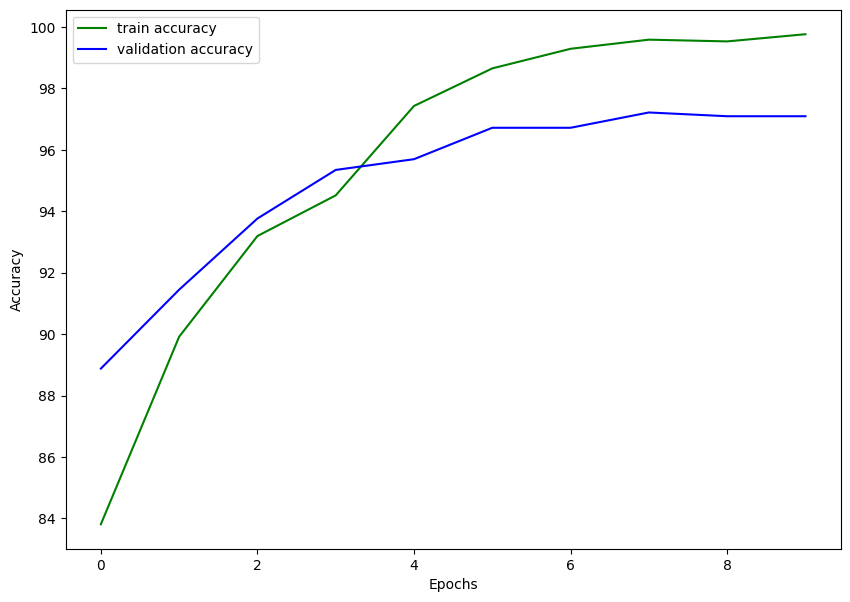

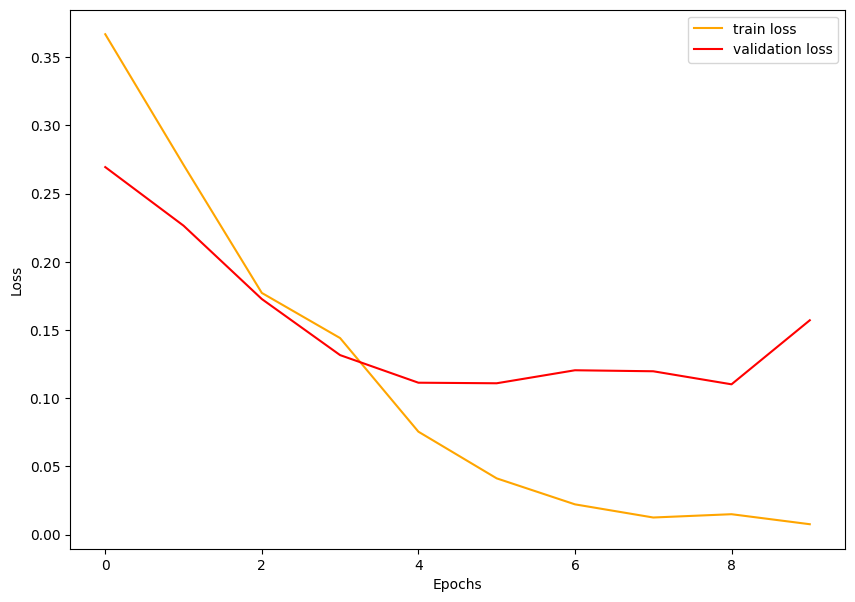

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validation accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss'
)
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validation loss'
)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


## Test

In [15]:
# Test

def test(model, testloader, criterion):
    model.eval()
    print('Testing')
    test_running_loss = 0.0
    test_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels.float())
            test_running_loss += loss.item()
            # calculate the accuracy
            preds = torch.round(outputs)
            test_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = test_running_loss / counter
    epoch_acc = 100. * (test_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

test_loss, test_acc = test(model, test_dataloader, criterion)
print(f"Test loss: {test_loss:.3f}, test acc: {test_acc:.3f}")



Testing


100%|██████████| 56/56 [00:05<00:00, 10.55it/s]

Test loss: 0.141, test acc: 97.302


* LSTMs are better than vanillas RNN in capturing context but as setences gets long, it suffers a lot. The impact of words gets less as the LSTM slides through later part of the sentence.
